# CNN and GAN

In [11]:
# imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, LeakyReLU, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import os

print(tf.version.VERSION)

2.5.0


In [12]:
# loading the mnist dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train_classes), (x_test, y_test_classes) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# preparation
num_classes = 10
num_train = x_train.shape[0]
num_test = x_train.shape[0]
img_width = x_train.shape[1]
img_height = x_train.shape[2]
img_size_flat = img_width * img_height

# one-hot encoding
y_train = np.eye(num_classes, dtype = float)[y_train_classes]
y_test = np.eye(num_classes, dtype = float)[y_test_classes]

# normalize input to [0,1]
x_train = x_train / 255
x_test = x_test / 255

# create tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)

preparing data augmentation

In [13]:
def add_noise(img):
    #VARIABILITY = 50
    #deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, 0.1, img.shape)
    result = img + noise
    np.clip(result, 0, 1)
    return result

In [14]:
# data augmentation: shifting, rotating and zooming into the images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.125, fill_mode = 'constant'),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode = 'constant'),
    layers.experimental.preprocessing.RandomZoom((0.2, -0.1), (0.2, -0.1), fill_mode = 'constant')
])

def prepare_data(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y), num_parallel_calls = tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

0.0 0.9960777


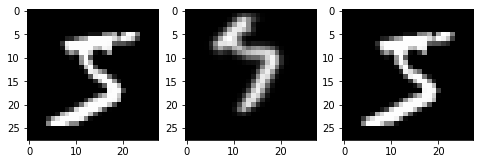

In [15]:
test_image0 = train_dataset.as_numpy_iterator().next()[0][:][:][0]
train_dataset = prepare_data(train_dataset)
_, ax = plt.subplots(1, 3, figsize = (8,4))
ax[0].imshow(test_image0, cmap = 'gray')
ax[1].imshow(train_dataset.as_numpy_iterator().next()[0][:][:][0], cmap = 'gray')
ax[2].imshow(x_train[0], cmap = 'gray')
print(train_dataset.as_numpy_iterator().next()[0].min(), train_dataset.as_numpy_iterator().next()[0].max())

In [16]:
# creating the cnn model
def make_cnn_model():
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(Conv2D(filters = 8, kernel_size = (3,3), input_shape = (img_height, img_width, 1)))
    cnn_model.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_model.add(MaxPooling2D())
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_model.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_model.add(MaxPooling2D())
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(num_classes, activation = 'softmax'))

    cnn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])
    #cnn_model.summary()
    return cnn_model

In [17]:
# creating a copy of the cnn model without softmax at the end
def make_cnn_model_without_softmax(cnn_model):
    cnn_no_softmax = tf.keras.models.Sequential()
    cnn_no_softmax.add(Conv2D(filters = 8, kernel_size = (3,3), input_shape = (img_height, img_width, 1)))
    cnn_no_softmax.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_no_softmax.add(MaxPooling2D())
    cnn_no_softmax.add(Dropout(0.25))
    cnn_no_softmax.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_no_softmax.add(Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'))
    cnn_no_softmax.add(MaxPooling2D())
    cnn_no_softmax.add(Dropout(0.25))
    cnn_no_softmax.add(Flatten())
    cnn_no_softmax.add(Dense(num_classes))
    # init weights
    cnn_no_softmax(tf.ones((1, img_height, img_width, 1)))
    # copy weights
    cnn_no_softmax.set_weights(cnn_model.get_weights())
    return cnn_no_softmax

In [18]:
# load the model if it already exists
# otherwise create and train it
if(os.path.exists('mnist_cnn_model')):
    cnn_model = tf.keras.models.load_model('mnist_cnn_model')
else:
    cnn_model = make_cnn_model()
    cnn_history = cnn_model.fit(x_train,
                                y_train,
                                epochs = 20,
                                validation_split = 0.2,
                                verbose = 0,
                                batch_size = 64)
    cnn_model.save('mnist_cnn_model')
    
cnn_no_softmax = make_cnn_model_without_softmax(cnn_model)

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [ ]:
# test the cnn model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)

In [ ]:
# compare outputs of both cnn models
real_img = np.expand_dims(x_train[1], 0)
print(cnn_model(real_img))
print(cnn_no_softmax(real_img))
plt.imshow(real_img[0,:,:,0], cmap = 'gray')

In [ ]:
# function to make a generator model
# from https://www.tensorflow.org/tutorials/generative/dcgan
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias = False, input_shape = (100, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [ ]:
# function to make the discriminator model
# from https://www.tensorflow.org/tutorials/generative/dcgan
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [ ]:
# define loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# define augmentation for the generator
def prepare_gen_data(ds):
    ds = ds.map(lambda x: (data_augmentation(x, training = True)), num_parallel_calls = tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
def generate_and_save_image(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize = (4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:,0], cmap = 'gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# define the training loop
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = prepare_gen_data(dataset)

# train step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, checkpoint_prefix, GAN_checkpoint):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
            
        # save a checkpoint every 15 epochs
        if (epoch + 1) % 15 == 0:
            GAN_checkpoint.save(file_prefix = checkpoint_prefix)
        if (epoch + 1) % 50 == 0:
            generate_and_save_image(generator, epoch, seed)
        #print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

In [ ]:
discriminator = make_discriminator_model()
generator = make_generator_model()
checkpoint_dir = './GAN_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
GAN_checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                    discriminator_optimizer = discriminator_optimizer,
                                    generator = generator,
                                    discriminator = discriminator)

if(os.path.exists('GAN_training_checkpoints')):
    GAN_checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:
    train(dataset, EPOCHS, checkpoint_prefix, GAN_checkpoint)

generating an example image and comparing with a real image

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
real_img = np.expand_dims(x_train[12], 0)
# plot both images
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(generated_image[0,:,:,0], cmap = 'gray')
ax[1].imshow(real_img[0,:,:,0], cmap = 'gray')
# discriminator output
print(discriminator(generated_image))
print(discriminator(real_img))
# cnn output
print(cnn_model(generated_image))
print(cnn_model(real_img))

In [ ]:
@tf.function
def target_function(x, index):
    y = cnn_no_softmax(x)
    y = tf.squeeze(y)
    p = y[index]
    print("p: ", p)
    return p

@tf.function
def saliency(x, index):
    #x_ = tf.cast(img, tf.float32) / 255.
    #x = tf.Variable(x_)
    with tf.GradientTape() as tape:
        p = target_function(x, index)
    grad = tape.gradient(p, x)
    grad_abs = tf.math.abs(grad)
    sal = (grad_abs - tf.math.reduce_min(grad_abs))/(tf.math.reduce_max(grad_abs) - tf.math.reduce_min(grad_abs))
    return grad

generating the saliency map for the image

In [ ]:
index = tf.argmax(tf.squeeze(cnn_model(real_img))).numpy()
x_ = tf.cast(real_img, tf.float32)
x = tf.Variable(x_)
sal = saliency(x, index)
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(real_img[0,:,:,0], cmap = 'gray')
ax[1].imshow(sal[0,:,:,0], cmap = 'bwr')

# fooling the CNN

In [ ]:
target_class = 9

In [ ]:
# make a tensorflow version of the image: scaled to [0,1] and with the extra dimension for the channel
x_ = tf.cast(real_img, tf.float32)

# create a tensorflow variable with respect to which we can differentiatiate
x = tf.Variable(x_) # initialize x with the original image

# get the vector of predicted probabilities for the original image
orig_y = cnn_model(x).numpy().squeeze()

In [ ]:
@tf.function
def target_function2(x):
    y = cnn_model(x)
    y = tf.squeeze(y)
    target_prob = y[target_class]
    return target_prob

In [ ]:
target_function2(real_img)

maximizing the target probability:

In [ ]:
max_iter = 600
max_change = 0.005     # maximum change per iteration and pixel
min_alpha = 100000     # a high value may be necessary to escape a local maximum
close_enough = False
epsilon = 1e-16
iter = 0

while not close_enough and iter < max_iter:
    with tf.GradientTape() as tape:
        p = target_function2(x)
    grad = tape.gradient(p, x)
    max_grad = tf.abs(tf.reduce_max(grad))
    alpha = tf.minimum(100000, max_change/tf.maximum(max_grad, epsilon))
    if(iter % 10 == 0):
        #print("alpha: ", alpha, " max_grad: ", max_grad)
        pass
    x.assign(x + alpha * grad)
    x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
    iter += 1
    if (p > 0.9999): # replace the 0 with the current value of the target_fkt
        close_enough = True

In [ ]:
target_prob = target_function2(x).numpy()
print("probability of class ", target_class, "is", target_prob)
print(orig_y)
print(cnn_model(x).numpy().squeeze())

In [ ]:
plt.imshow(real_img[0,:,:,0], cmap = 'gray')

In [ ]:
plt.imshow(x[0,:,:,0], cmap = 'gray')
discriminator(x)

In [ ]:
with tf.GradientTape() as tape:
    prob = target_function2(x)
saliency = tape.gradient(prob, x)
plt.imshow(saliency[0,:,:,0], cmap = 'bwr')
print(tf.reduce_max(saliency))

$ g(x) = - \ln P(x) + \ln P(y|x) = - \ln P(x) + \ln f(x) $ \
use gradient descend to minimize $g(x)$ \
$ x_{\text{new} } = x - \alpha \cdot \nabla g(x) $ \
tf.GradientTape needs to evaluate the function to get the gradient. \
This is a problem because the discriminator can return negative values. \
To avoid evaluating the natural log at negative values the following property of its derivative can be used: \
$ \frac{d}{dx} \ln (-x) = \frac{1}{-x} \cdot -1 = \frac{1}{x} = \frac{d}{dx} \ln (x) $ \
calculate the gradient of $ g $ explicitely: \
$ \frac{d}{dx} g(x) = \frac{d}{dx} \ln (f(x)) - \frac{d}{dx} \ln(P(x)) = \frac{1}{f(x)}f'(x) - \frac{1}{P(x)}P'(x) $

In [ ]:
# reset x to original image
# make a tensorflow version of the image: scaled to [0,1] and with the extra dimension for the channel
x_ = tf.cast(real_img, tf.float32)

# create a tensorflow variable with respect to which we can differentiatiate
x = tf.Variable(x_) # initialize x with the original image

# get the vector of predicted probabilities for the original image
orig_y = cnn_model(x).numpy().squeeze()
#plt.imshow(x[0,:,:,0], cmap = 'gray')

In [ ]:
with tf.GradientTape() as tape:
    p = discriminator(x)
grad_p = tape.gradient(p, x)

with tf.GradientTape() as tape:
    f = cnn_no_softmax(x)
grad_f = tape.gradient(f, x)

_, ax = plt.subplots(1, 3, figsize = (8,4))
ax[0].imshow(grad_p[0,:,:,0], cmap = 'bwr')
ax[0].set_title("saliency map of the discriminator")
ax[1].imshow(grad_f[0,:,:,0], cmap = 'bwr')
ax[1].set_title("saliency map of the classifier")
ax[2].imshow(x[0,:,:,0], cmap = 'gray')
ax[2].set_title("input")

# algorithm version 1:
## reducing the probability of the originaly prediction while increasing the discriminator output

In [ ]:
# algorithm
max_iter = 600
max_change = 0.005     # maximum change per iteration and pixel
min_alpha = 100000     # a high value may be necessary to escape a local maximum
close_enough = False
epsilon = 1e-16
iter = 0

index = tf.argmax(tf.squeeze(cnn_model(x))).numpy()

while not close_enough and iter < max_iter:
    # derive discriminator
    with tf.GradientTape() as tape:
        p = discriminator(x)
    grad_p = tape.gradient(p, x)
    # derive classifier
    with tf.GradientTape() as tape:
        f = tf.squeeze(cnn_no_softmax(x))[index]
    grad_f = tape.gradient(f, x)
    
    max_grad_p = tf.abs(tf.reduce_max(grad_p))
    max_grad_f = tf.abs(tf.reduce_max(grad_f))
    max_grad = tf.maximum(max_grad_p, max_grad_f)
    alpha = tf.minimum(100000, max_change/tf.maximum(max_grad, epsilon))
    
    if(iter % 10 == 0):
        #print("grad_p/p: ", grad_p/p, " grad_f/f: ", grad_f/tf.reduce_max(f))
        pass
    
    x.assign(x - alpha * ((grad_p/p) - (grad_f/tf.reduce_max(f))))
    x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
    iter += 1
    new_index = tf.argmax(tf.squeeze(cnn_model(x))).numpy()
    if ((new_index != index) and (discriminator(x).numpy() > 0)): # done when the prediction has changed
        close_enough = True

In [ ]:
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x[0,:,:,0], cmap = 'gray')
ax[1].imshow(real_img[0,:,:,0], cmap = 'gray')
print(discriminator(x))
print(cnn_model(x))

In [ ]:
with tf.GradientTape() as tape:
    p = discriminator(x)
grad_p = tape.gradient(p, x)

with tf.GradientTape() as tape:
    f = cnn_no_softmax(x)
grad_f = tape.gradient(f, x)

_, ax = plt.subplots(1, 3, figsize = (8,4))
ax[0].imshow(grad_p[0,:,:,0], cmap = 'bwr')
ax[0].set_title("saliency map of the discriminator")
ax[1].imshow(grad_f[0,:,:,0], cmap = 'bwr')
ax[1].set_title("saliency map of the classifier")
ax[2].imshow(x[0,:,:,0], cmap = 'gray')
ax[2].set_title("input")

# algorithm version 2
increasing the output for a class that looks similar to the correct class
for example:
3 and 9,
3 and 8,
4 and 9,
8 and 9,
0 and 9
while increasing the discriminator output